In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
pd.pandas.set_option('display.max_columns',None)
import seaborn as sns

## Loading Data

In [2]:
rating = pd.read_csv('BX-Book-Ratings.csv', encoding='latin-1', on_bad_lines='warn',sep=';')
book = pd.read_csv('BX-Books.csv', encoding='latin-1', on_bad_lines='warn',sep=';')
#user = pd.read_csv('BX-Users.csv', encoding='latin-1', on_bad_lines='warn',sep=';')

Skipping line 6452: expected 8 fields, saw 9
Skipping line 43667: expected 8 fields, saw 10
Skipping line 51751: expected 8 fields, saw 9

Skipping line 92038: expected 8 fields, saw 9
Skipping line 104319: expected 8 fields, saw 9
Skipping line 121768: expected 8 fields, saw 9

Skipping line 144058: expected 8 fields, saw 9
Skipping line 150789: expected 8 fields, saw 9
Skipping line 157128: expected 8 fields, saw 9
Skipping line 180189: expected 8 fields, saw 9
Skipping line 185738: expected 8 fields, saw 9

Skipping line 209388: expected 8 fields, saw 9
Skipping line 220626: expected 8 fields, saw 9
Skipping line 227933: expected 8 fields, saw 11
Skipping line 228957: expected 8 fields, saw 10
Skipping line 245933: expected 8 fields, saw 9
Skipping line 251296: expected 8 fields, saw 9
Skipping line 259941: expected 8 fields, saw 9
Skipping line 261529: expected 8 fields, saw 9

C:\Users\risha\AppData\Local\Temp\ipykernel_4392\1846637563.py:2: DtypeWarning: Columns (3) have mixed ty

In [3]:
book.head(2)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...


In [4]:
rating.head(2)

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5


In [5]:
print("Books:",book.shape)
#print("Users:",user.shape)
print("Ratings:",rating.shape)

Books: (271360, 8)
Ratings: (1149780, 3)


# Data Preprocessing

In [6]:
book.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

In [7]:
rating.isnull().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

In [8]:
book = book[['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher', 'Image-URL-L']]

URLs linking to cover images are also given, appearing in three different flavours (Image-URL-S, Image-URL-M, Image-URL-L), i.e., small, medium, large

### Handling Missing Values

In [9]:
book[book['Book-Author'].isnull()]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L
118033,0751352497,A+ Quiz Masters:01 Earth,NaN,1999,Dorling Kindersley,http://images.amazon.com/images/P/0751352497.0...
187689,9627982032,The Credit Suisse Guide to Managing Your Perso...,NaN,1995,Edinburgh Financial Publishing,http://images.amazon.com/images/P/9627982032.0...


After some google searches, we find that the author of the book 'The Credit Suisse Guide to Managing Your Personal Wealth' is:
<b>
Downes, Larissa Ann<b>e

In [10]:
book.at[187689, 'Book-Author'] = 'Downes, Larissa Anne'

In [11]:
book[book['Publisher'].isnull()]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN,http://images.amazon.com/images/P/193169656X.0...
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN,http://images.amazon.com/images/P/1931696993.0...


The Publisher of both the book was 'NovelBooks, Incorporated', here is link if you want to check<br>
[Tyrant Moon](https://books.google.co.in/books/about/Tyrant_Moon.html?id=RSwAvp1VOe8C&source=kp_book_description&redir_esc=y) <br>
[Finders Keepers](https://books.google.co.in/books?id=M9pbPgAACAAJ&source=gbs_book_other_versions&redir_esc=y)

In [12]:
book.at[128890, 'Publisher'] = 'Mundania Press'
book.at[129037, 'Publisher'] = 'NovelBooks, Incorporated'

In [13]:
book[book['Image-URL-L'].isnull()]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,NaN
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...,NaN
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...,NaN


The values are mismatched: the book title and author names are mixed up. For instance, the title should be "DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)" and the author should be "James Buckley". Since 209538 is the same book as 221678, just with "Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)" written by the authors "James Buckley" and "Michael Teitelbaum". For verification use this [link](https://books.google.co.in/books/about/Creating_the_X_men.html?id=GKF6Rc0mgNgC&redir_esc=y). 

In [14]:
book.at[209538, 'Book-Title'] ='Creating the X-Men, How Comic Books Come to Life (Level 4)'
book.at[209538, 'Book-Author'] = 'James Buckley,Michael Teitelbaum'
book.at[209538, 'Year-Of-Publication'] = '2000'
book.at[209538, 'Publisher'] = 'DK Publishing Inc'
book.at[209538, 'Image-URL-L'] = 'http://images.amazon.com/images/P/0789466953.01.THUMBZZZ.jpg'

In [15]:
book[book['ISBN']=='078946697X'].values.tolist()

[['078946697X',
  'Creating the X-Men, How Comic Books Come to Life (Level 4)',
  'James Buckley,Michael Teitelbaum',
  '2000',
  'DK Publishing Inc',
  'http://images.amazon.com/images/P/0789466953.01.THUMBZZZ.jpg']]

In [16]:
book.at[220731, 'Book-Title'] ='Peuple du ciel, suivi de'
book.at[220731, 'Book-Author'] = 'Jean-Marie Gustave Le Clézio'
book.at[220731, 'Year-Of-Publication'] = '2003'
book.at[220731, 'Publisher'] = 'Gallimard'
book.at[220731, 'Image-URL-L'] = 'http://images.amazon.com/images/P/2070426769.01.THUMBZZZ.jpg'

In [17]:
book.at[3543, 'Year-Of-Publication']=1986

In [18]:
book[book['ISBN']=='2070426769'].values.tolist()

[['2070426769',
  'Peuple du ciel, suivi de',
  'Jean-Marie Gustave Le Clézio',
  '2003',
  'Gallimard',
  'http://images.amazon.com/images/P/2070426769.01.THUMBZZZ.jpg']]

### Drop the remaining missing values 

In [19]:
# Dropping the row at index 220731 since it's a duplicate book book with same author
book = book.drop(index=221678)
book = book.drop(index=118033)

In [20]:
book.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
Image-URL-L            0
dtype: int64

In [21]:
book.shape

(271358, 6)

# EDA
### Checking Columns for Mistakes in Data
#### Book-Author

In [22]:
book['Book-Author'].value_counts().head(15)

Book-Author
Agatha Christie         632
William Shakespeare     567
Stephen King            524
Ann M. Martin           423
Carolyn Keene           373
Francine Pascal         372
Isaac Asimov            330
Nora Roberts            315
Barbara Cartland        307
Charles Dickens         302
Not Applicable (Na )    286
R. L. Stine             282
Mark Twain              231
Jane Austen             223
Terry Pratchett         220
Name: count, dtype: int64

There are lot of books with no author name

#### Book Author containing Symbol (>)

In [23]:
book[book['Book-Author'].str.contains(r'>', regex=True, na=False)]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L
15404,2070567842,Folio Junior: L'histoire De Monsieur Sommer,Su>skind-Sempe,0,Gallimard-Jeunesse,http://images.amazon.com/images/P/2070567842.0...
52778,3423705000,DTV Junior: Emil Und Die Detektive,Ka>stner,0,Deutscher Taschenbuch Verlag (DTV),http://images.amazon.com/images/P/3423705000.0...


In [24]:
book.at[52778, 'Book-Author']='Erich Kästner'
book.at[52778, 'Year-Of-Publication']=1991

In [25]:
book[book['Book-Author'].str.contains(r'@', regex=True, na=False)]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L
163148,1580080707,Cybercafes: A Worldwide Guide for Travelers,cyberkath@traveltales.com,1999,Ten Speed Press,http://images.amazon.com/images/P/1580080707.0...


In [26]:
book.at[163148, 'Book-Author']='Cyberkath Traveltales'

#### Book Author containing only 2 letters

In [27]:
book[book['Book-Author'].str.match(r'^[a-zA-Z]{2}$', na=False)]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L
28171,0395556376,Fate: New Poems,Ai,1991,Houghton Mifflin,http://images.amazon.com/images/P/0395556376.0...
75343,0380018853,Complete Runner,Ed,1983,Avon Books,http://images.amazon.com/images/P/0380018853.0...
104544,0060977612,God Is My Broker: A Monk-Tycoon Reveals the 7 ...,Ty,1999,Perennial,http://images.amazon.com/images/P/0060977612.0...
108819,0786834617,"Annette Mysteries, The - Box Set of 4 (Walt Di...",tk,2003,Disney Press,http://images.amazon.com/images/P/0786834617.0...
116382,0888888880,The Circle,Na,1999,Not Avail,http://images.amazon.com/images/P/0888888880.0...
123695,0786845848,The Lizzie McGuire Movie: Jr. Novel,tk,2003,Disney Press,http://images.amazon.com/images/P/0786845848.0...
130250,0590541781,Little Theme (My First Library),Na,1995,Scholastic,http://images.amazon.com/images/P/0590541781.0...
154042,0889627657,Wild Things Live Here: The Best of Northern Fr...,Na,2002,Mosaic Press,http://images.amazon.com/images/P/0889627657.0...
159340,3499430916,"Blut Will Der Damon (Fiction, Poetry and Drama)",Ky,0,Rowohlt Taschenbuch Verlag GmbH,http://images.amazon.com/images/P/3499430916.0...
166826,349920360X,HeiÃ?Â?t du wirklich Hassan Schmidt? Ein Krimi...,ky,1997,Rowohlt Tb.,http://images.amazon.com/images/P/349920360X.0...


In [28]:
#Fate: New Poems
book.at[28171, 'Book-Author']='Al Ogawa'
#Complete Runner
book.at[75343, 'Book-Author']="Runner's World Magazine"
#God Is My Broker: A Monk-Tycoon Reveals the 7 1/2 Laws of Spiritual and Financial Growth
book.at[104544, 'Book-Author']='Christopher Buckley and John Tierney'
#Annette Mysteries, The - Box Set of 4 (Walt Disney Presents)
book.at[108819	, 'Book-Title'] ="The Annette Mysteries collectionsr"
book.at[108819	, 'Book-Author'] ="Doris Schroeder"
#The Lizzie McGuire Movie: Jr. Novel
book.at[123695	, 'Book-Author'] ="david cody weiss"
#book=book.drop(130250)
#Wild Things Live Here: The Best of Northern Frights
book.at[154042, 'Book-Author']='Don Hutchison'
#Blut Will Der Damon (Fiction, Poetry and Drama)
book.at[159340, 'Book-Author']='Horst Bosetzky'
book.at[159340, 'Year-Of-Publication']=1993
#HeiÃ?Â?t du wirklich Hassan Schmidt? Ein Krimi. ( Ab 13 J.).'	
book.at[166826, 'Book-Author']='Horst Bosetzky'
book.at[166826, 'Book-Title']="Heißt du wirklich Hasan Schmidt?"
#Bh New Cookbook
book.at[191218, 'Book-Author']='Better Homes and Gardens'
book.at[191218, 'Book-Title']="Better Homes and Gardens New Cook Book"
book = book.drop(197735)
book = book.drop(203968)
book.at[219235, 'Year-Of-Publication']=1989
#Walt Disney's Santa's Toy Shop : Walt Disney Classic Edition (Walt Disney Classics (Hardcover))
book.at[243506	, 'Book-Title'] ="Walt Disney's Santa's Toy Shop"
book.at[243506	, 'Book-Author'] ="Al Dempster"
#Deutsche Gedichte
book.at[256126, 'Book-Author']="Paul Fleming, Volker Meid"
#Bh Crockery Cookery
book.at[261900, 'Book-Author']='Better Homes and Gardens'
book.at[261900, 'Book-Title']="Crockery Cooking (Better Homes and Gardens)"
#Easy Style Decorating Shortcuts
book.at[263394, 'Book-Author']='Better Homes and Gardens'

#### 4 books with 'Book-Author' name as x x

In [29]:
book[book['Book-Author']=='x x']

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L
149212,1591050367,An American Redneck in Hong Kong,x x,2002,"NovelBooks, Inc.",http://images.amazon.com/images/P/1591050367.0...
207132,1931696837,Unlawful,x x,2002,"NovelBooks, Inc.",http://images.amazon.com/images/P/1931696837.0...
212941,1591050804,Winter Fire,x x,2002,"NovelBooks, Inc.",http://images.amazon.com/images/P/1591050804.0...
234548,1931696810,Mating Season,x x,2002,"NovelBooks, Inc.",http://images.amazon.com/images/P/1931696810.0...


In [30]:
book.at[149212	, 'Book-Author'] ="Michael LaRocca"
book.at[207132	, 'Book-Author'] ="Dorice Nelson"
book.at[212941	, 'Book-Author'] ="Kathy Fischer-Brown"
book.at[234548	, 'Book-Author'] ="Liz Hunter"

#### 2 books with 'Book-Author' name is unknown

In [31]:
book[book['Book-Author']=='unknown']

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L
96703,1561449164,Pound It (Popular Mechanics for Kids),unknown,1997,Modern Publishing,http://images.amazon.com/images/P/1561449164.0...
267861,0960638822,A Course In Miracles Workbook for students Man...,unknown,1985,Foundation For Inner Peace,http://images.amazon.com/images/P/0960638822.0...


In [32]:
book.at[267861	, 'Book-Title'] ='A Course In Miracles Workbook for students Manual for Teachers'
book.at[267861	, 'Book-Author'] ="Helen Schucman"
book = book.drop(96703)

'Pound It (Popular Mechanics for Kids)', It's a toy & book in one there is no author

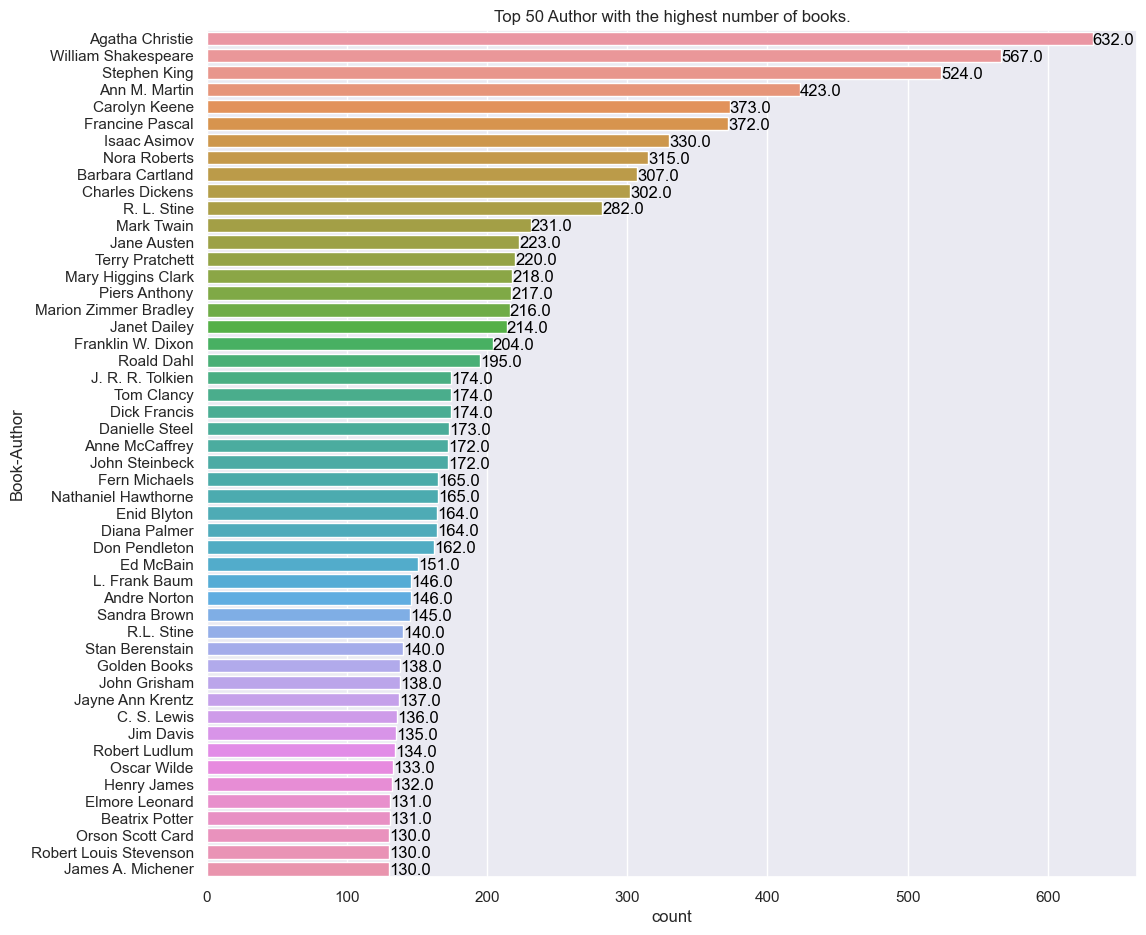

In [33]:
top_authors = book[book['Book-Author'] != 'Not Applicable (Na )']['Book-Author'].value_counts().head(50).index

sns.set(style='darkgrid')
plt.figure(figsize=(12,11))

# Create a barplot of Average-Rating vs Book-Title
ax = sns.countplot(y='Book-Author', data=book[book['Book-Author'].isin(top_authors)], order=top_authors)

# Add labels to each bar (Average-Rating values)
for i in ax.patches:
    ax.text(i.get_width() + 0.05, i.get_y() + 0.5, f'{i.get_width():.1f}', 
            fontsize=12, color='black', va='center')

plt.title('Top 50 Author with the highest number of books.')
plt.show()

### Publisher

In [34]:
book['Publisher'].value_counts().head(20)

Publisher
Harlequin                   7535
Silhouette                  4220
Pocket                      3905
Ballantine Books            3783
Bantam Books                3646
Scholastic                  3160
Simon &amp; Schuster        2971
Penguin Books               2844
Berkley Publishing Group    2771
Warner Books                2727
Penguin USA                 2717
Harpercollins               2525
Fawcett Books               2258
Signet Book                 2070
Random House Inc            2045
St Martins Pr               1953
St. Martin's Press          1783
Tor Books                   1704
HarperCollins Publishers    1700
Zebra Books                 1694
Name: count, dtype: int64

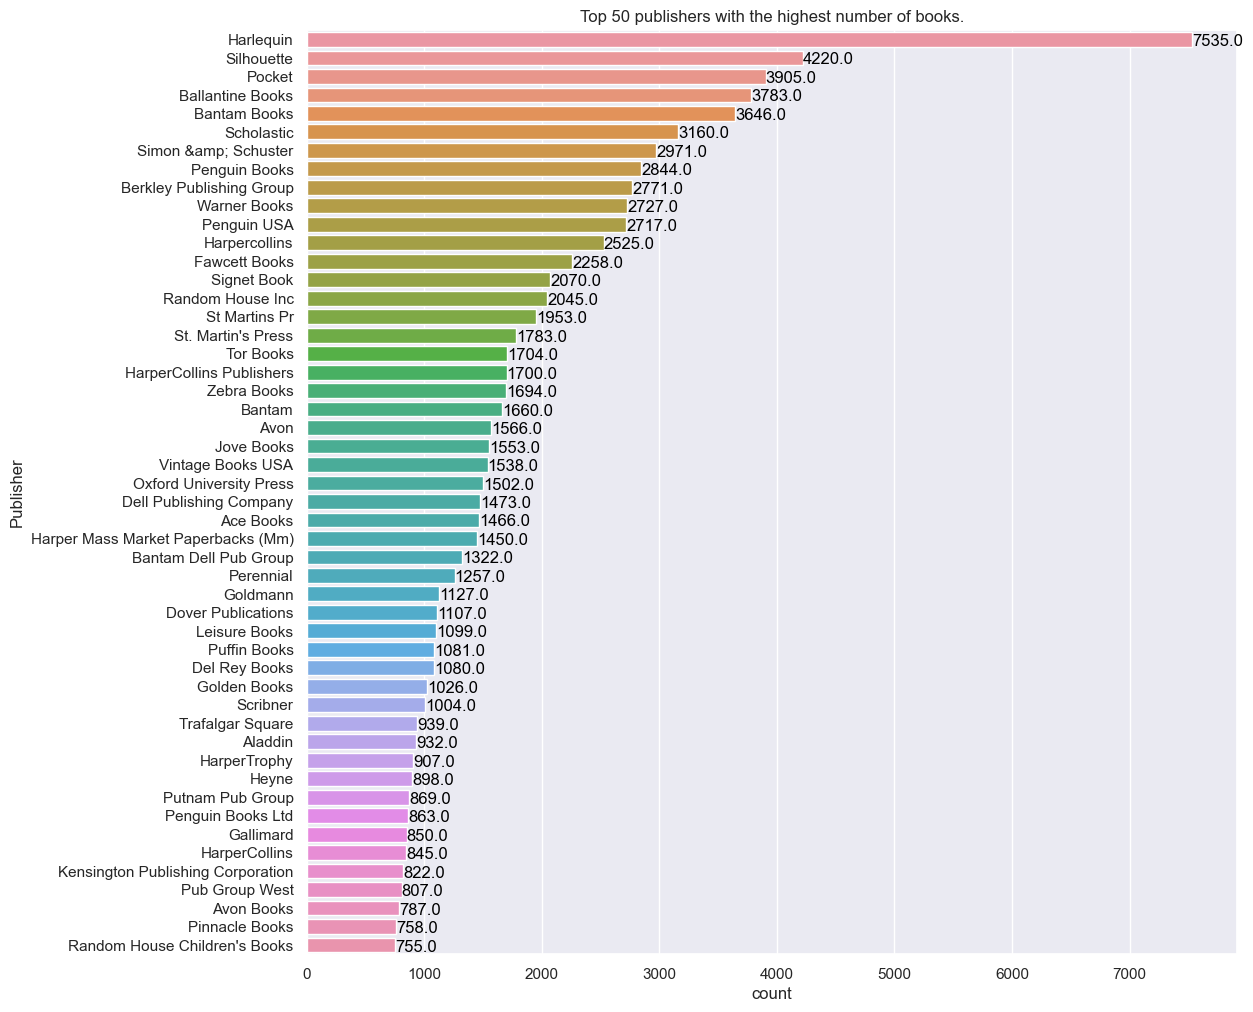

In [35]:
top_Publisher=book['Publisher'].value_counts().head(50).index
# Set a different style and color palette
sns.set(style='darkgrid')
plt.figure(figsize=(12,12))

# Create a barplot of Average-Rating vs Book-Title
ax = sns.countplot(y='Publisher', data=book[book['Publisher'].isin(top_Publisher)], order=top_Publisher)

# Add labels to each bar (Average-Rating values)
for i in ax.patches:
    ax.text(i.get_width() + 0.05, i.get_y() + 0.5, f'{i.get_width():.1f}', 
            fontsize=12, color='black', va='center')

plt.title('Top 50 publishers with the highest number of books.')
plt.show()

### Year-Of-Publication

In [36]:
book['Year-Of-Publication'].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

There are a few values showing the year of publication as more than 2024, which is not possible.

In [37]:
book = book.copy()
book['Year-Of-Publication']=book['Year-Of-Publication'].astype('int64')

In [38]:
book['Year-Of-Publication'].value_counts().sort_index(ascending=False).head(10)

Year-Of-Publication
2050    2
2038    1
2037    1
2030    7
2026    1
2024    1
2021    1
2020    3
2012    1
2011    2
Name: count, dtype: int64

In [39]:
book['Year-Of-Publication'].value_counts().sort_index(ascending=True).head(10)

Year-Of-Publication
0       4614
1376       1
1378       1
1806       1
1897       1
1900       3
1901       7
1902       2
1904       1
1906       1
Name: count, dtype: int64

In [40]:
book[book['Year-Of-Publication']>2010][['ISBN','Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher']]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
12782,0380816792,A Rose in Winter,Kathleen E. Woodiwiss,2011,Harper Mass Market Paperbacks
30010,068160204X,The Royals,Kitty Kelley,2020,Bausch &amp; Lombard
37487,0671746103,MY TEACHER FRIED MY BRAINS (RACK SIZE) (MY TEA...,Coville,2030,Aladdin
55676,0671791990,MY TEACHER FLUNKED THE PLANET (RACK SIZE) (MY ...,Bruce Coville,2030,Aladdin
78168,0870449842,Crossing America,National Geographic Society,2030,National Geographic
80264,0140301690,Alice's Adventures in Wonderland and Through t...,Lewis Carroll,2050,Puffin Books
92156,068107468X,Edgar Allen Poe Collected Poems,Edgar Allan Poe,2020,Bausch &amp; Lombard
97826,0140201092,Outline of European Architecture (Pelican S.),Nikolaus Pevsner,2050,Penguin USA
116053,0394701658,Three Plays of Eugene Oneill,Eugene O'Neill,2038,Vintage Books USA
118294,3442436893,Das groÃ?Â?e BÃ?Â¶se- MÃ?Â¤dchen- Lesebuch.,Kathy Lette,2026,Goldmann


In [41]:
#In Our Time: Stories (Scribner Classic)
book.at[240169, 'Year-Of-Publication'] =1958
#CLOUT
book.at[246842, 'Year-Of-Publication'] =1995
#Monkey (An Evergreen Book, E-112)
book.at[235425, 'Year-Of-Publication'] =1943
#FOOTBALL SUPER TEAMS : FOOTBALL SUPER TEAMS
book.at[260974, 'Year-Of-Publication'] =1991
#To Have and Have Not
book.at[255409, 'Year-Of-Publication'] =1991
book.at[255409, 'Publisher'] ="Charles Scribner's Sons"
#Outline of European Architecture (Pelican S.)
book.at[97826, 'Year-Of-Publication'] =1990
#Owl's Amazing but True No. 2	
book.at[199196, 'Year-Of-Publication'] =1983
book.at[199196, 'Book-Author'] ='Laima Dingwall'
book.at[199196, 'Publisher'] ="Western Publishing Company"
#FOREST PEOPLE (Touchstone Books (Hardcover))	
book.at[228173, 'Year-Of-Publication'] =1987
book.at[228173, 'Book-Title'] ='The Forest People'
book.at[228173, 'Publisher'] ="Touchstone"
#Field Guide to the Birds of North America, 3rd Ed
book.at[192993, 'Year-Of-Publication'] =1999
#Das groÃ?Â?e BÃ?Â¶se- MÃ?Â¤dchen- Lesebuch.
book.at[118294, 'Year-Of-Publication'] =2006
book.at[118294, 'Book-Title'] ='Das große Böse- Mädchen- Lesebuch'
#Three Plays of Eugene Oneill
book.at[116053, 'Year-Of-Publication'] =1995
book.at[116053, 'Publisher'] ="Vintage Books"
#Alice's Adventures in Wonderland and Through the Looking Glass (Puffin Books)
book.at[80264, 'Year-Of-Publication'] =2003
book.at[80264, 'Publisher'] ="Penguin Books"
#Crossing America
book.at[78168, 'Year-Of-Publication'] =1999
#MY TEACHER FLUNKED THE PLANET (RACK SIZE) (MY TEACHER BOOKS)
book.at[55676, 'Year-Of-Publication'] =1992
#The Royals
book.at[30010, 'Year-Of-Publication'] =1998
book.at[30010, 'Publisher'] ="Hachette Book Group USA"
#'MY TEACHER FRIED MY BRAINS (RACK SIZE) (MY TEACHER BOOKS)
book.at[37487, 'Year-Of-Publication'] =1991
book.at[37487, 'Book-Author'] =' Bruce Coville'
#Edgar Allen Poe Collected Poems
book.at[92156, 'Year-Of-Publication'] =2013
book.at[92156, 'Book-Title'] ='The Poems of Edgar Allan Poe'
book.at[92156, 'Publisher'] ="Courier Corporation"

In [42]:
book[(book['Year-Of-Publication']<1900)&(book['Year-Of-Publication']>0)]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L
171817,0781228956,"Complete Works 10 Volumes [2,6,7,8,9] (Notable...",Benjamin Franklin,1806,Reprint Services Corp,http://images.amazon.com/images/P/0781228956.0...
227531,9643112136,Dalan-i bihisht (Dastan-i Irani),Nazi Safavi,1378,Intisharat-i Quqnus,http://images.amazon.com/images/P/9643112136.0...
245607,0781268001,"Hugh Wynne, Free Quaker (2 Volumes (BCL1-PS Am...",Silas Weir Mitchell,1897,Reprint Services Corp,http://images.amazon.com/images/P/0781268001.0...
253750,964442011X,Tasht-i khun,IsmaÂ°il Fasih,1376,Nashr-i Alburz,http://images.amazon.com/images/P/964442011X.0...


In [43]:
#Dalan-i bihisht (Dastan-i Irani)
book.at[227531	, 'Year-Of-Publication'] =2010

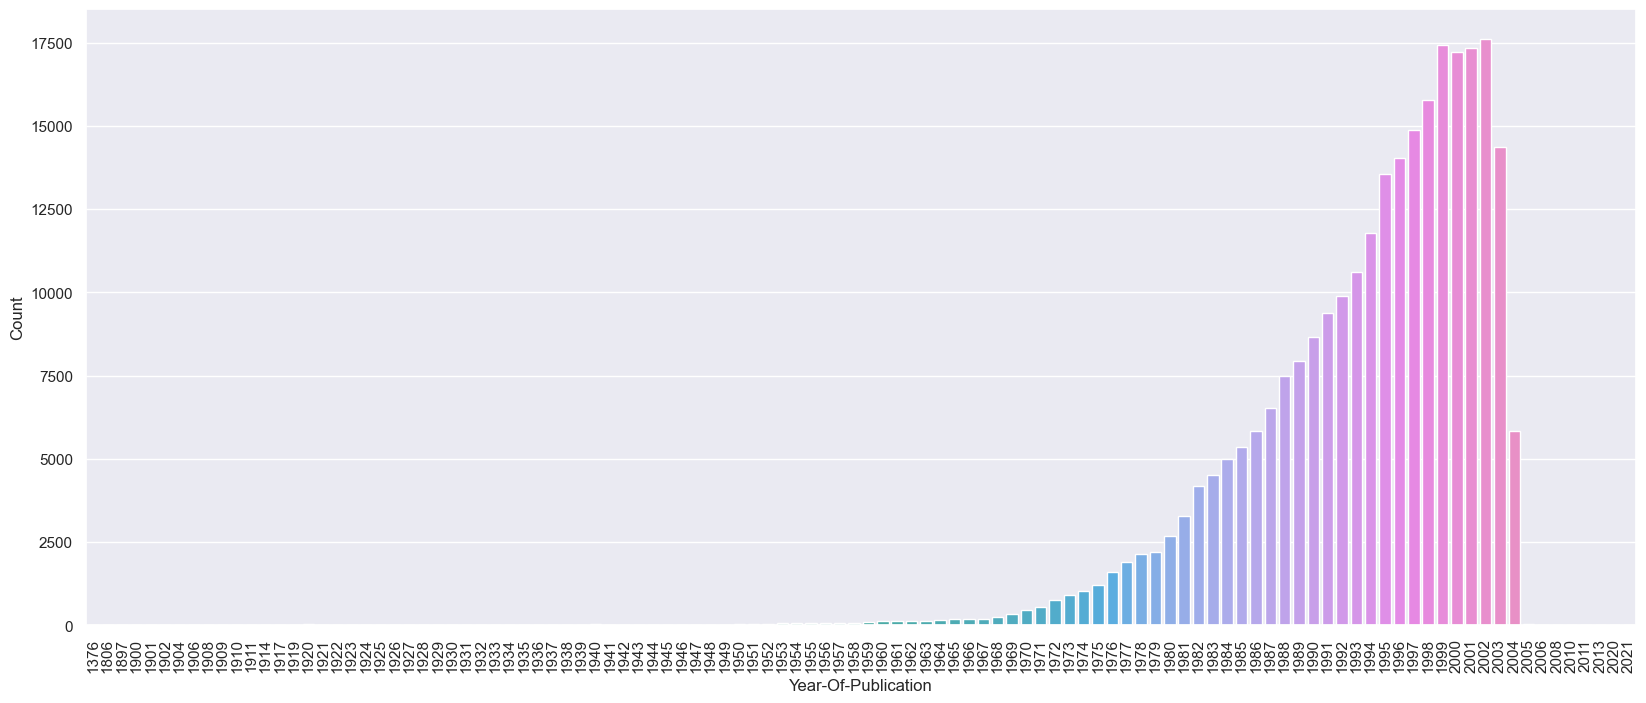

In [44]:
year_counts =  book[book['Year-Of-Publication'] != 0]['Year-Of-Publication'].value_counts().reset_index()
year_counts.columns = ['Year-Of-Publication', 'Count'] 
# Sorting the values by 'Year-Of-Publication'
year_counts = year_counts.sort_values('Year-Of-Publication')
# Setting the plot style
sns.set(rc={'figure.figsize':(20,8)})
# Creating the bar plot of the above obtained values
ax = sns.barplot(x=year_counts['Year-Of-Publication'], y=year_counts['Count'])
# Rotating x-axis labels for readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# Display the plot
plt.show()

We can observe that publication years range between 1950 and 2005. The publication of books became significant starting around 1950. The highest peak in book publications occurred between 1995 and 2001.

## Merging The Data

In [45]:
# Filter the ratings where ISBN is in the book dataset
filter_ratings = rating[rating['ISBN'].isin(book['ISBN'])]
filter_ratings

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
1149774,276704,0876044011,0
1149775,276704,1563526298,9
1149776,276706,0679447156,0
1149777,276709,0515107662,10


<li>This line filters the rating DataFrame to include only rows where the ISBN exists in the book DataFrame. 
<li>This step ensures that only ratings for books that are present in the book dataset are kept.

In [46]:
bookrating = pd.merge(filter_ratings, book, on="ISBN")
bookrating.head(2)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...


<li>This merges the filtered filter_ratings DataFrame with the book DataFrame on the ISBN column. 
<li>The result, book_rating, combines book details with their corresponding ratings.

In [47]:
bookrating.shape

(1031126, 8)

In [48]:
# Use these indices to filter the DataFrame, keeping only the rows with the highest rating for each title
book_rating = bookrating.groupby('Book-Title')['Book-Rating'].idxmax()
book_rating = bookrating.loc[book_rating]
book_rating.head(2)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L
575113,96448,0590567330,9,A Light in the Storm: The Civil War Diary of ...,Karen Hesse,1999,Hyperion Books for Children,http://images.amazon.com/images/P/0590567330.0...
954569,172742,0964147726,0,Always Have Popsicles,Rebecca Harvin,1994,Rebecca L. Harvin,http://images.amazon.com/images/P/0964147726.0...


In [49]:
book_rating.shape

(241064, 8)

### Calculating Average

In [50]:
avg_rating =  book_rating.groupby('Book-Title')['Book-Rating'].mean().reset_index()
avg_rating.rename(columns={'Book-Rating':'Average-Rating'}, inplace=True)
avg_rating.head()

,Book-Title,Average-Rating
0,A Light in the Storm: The Civil War Diary of ...,9.0
1,Always Have Popsicles,0.0
2,Apple Magic (The Collector's series),0.0
3,"Ask Lily (Young Women of Faith: Lily Series, ...",8.0
4,Beyond IBM: Leadership Marketing and Finance ...,0.0


#### Why take average?
<li>Average ratings allow for easy comparisons between books. This helps to rank books based on their perceived quality and popularity, which can be particularly useful when recommending the top books to users.
<li>Individual ratings can be noisy due to extreme values (very high or low ratings) that may not reflect the general consensus. Averaging helps reduce the impact of these outliers, leading to a more balanced view of the book’s reception.

In [51]:
avgbook_ratings = pd.merge(book_rating, avg_rating, on='Book-Title')
avgbook_ratings.head(2)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L,Average-Rating
0,96448,0590567330,9,A Light in the Storm: The Civil War Diary of ...,Karen Hesse,1999,Hyperion Books for Children,http://images.amazon.com/images/P/0590567330.0...,9.0
1,172742,0964147726,0,Always Have Popsicles,Rebecca Harvin,1994,Rebecca L. Harvin,http://images.amazon.com/images/P/0964147726.0...,0.0


The code merges book_rating with the avgdf DataFrame on the ISBN column. This step adds the average rating information to each record in book_rating

#### Observations
<li>The bulk of the average ratings are in the higher range (7.0 and above), with a particularly large concentration at 10.0 (37,012), followed by 8.0 (27,923), and 9.0 (21,548). This suggests that many books are generally well-received by readers.
<li>The dominance of these higher ratings indicates that users tend to rate books positively, which is common in rating systems as people are more likely to rate what they enjoy.
<li>Moderate average ratings are present but significantly fewer compared to higher ratings. Books in this range (5.0 and 6.0) might indicate mixed or average reception. However, they still receive more ratings than lower ranges, showing some level of engagement from readers.
<li>Ratings from 1.0 to 4.0 have relatively low counts, indicating that few books receive consistently low ratings. This could imply, Readers generally avoid rating books they strongly dislike, There might be a positive bias in the rating system where extreme low scores are less frequently given or shared, Books with consistently low ratings are less common or get filtered out over time.

In [52]:
avgbook_ratings['Average-Rating'].value_counts().sort_index(ascending=False)

Average-Rating
10.0     39309
9.0      22135
8.0      28220
7.0      18580
6.0       8595
5.0      14532
4.0       1936
3.0       1249
2.0        597
1.0        410
0.0     105501
Name: count, dtype: int64

### Calculate the Number of Ratings

In [53]:
#num_rating=avgdf.groupby('Book-Title').count()['Book-Rating'].sort_values(ascending=False).reset_index()
nonzero_rating = bookrating[bookrating['Book-Rating'] != 0]
num_rating = nonzero_rating.groupby('Book-Title')['Book-Rating'].count().reset_index()
num_rating.rename(columns={'Book-Rating':'Number-of-Rating'}, inplace=True)
num_rating

,Book-Title,Number-of-Rating
0,A Light in the Storm: The Civil War Diary of ...,1
1,"Ask Lily (Young Women of Faith: Lily Series, ...",1
2,Dark Justice,1
3,Earth Prayers From around the World: 365 Pray...,7
4,Final Fantasy Anthology: Official Strategy Gu...,2
...,...,...
135558,Ã?Â?bernachten mit Stil. Die schÃ?Â¶nsten Coun...,1
135559,Ã?Â?rger mit Produkt X. Roman.,3
135560,Ã?Â?sterlich leben.,1
135561,Ã?Â?stlich der Berge.,1


#### Reasons to Calculate the Number of Ratings After Averaging:
<li>When ranking books, a book with a higher number of ratings might be ranked higher even if another book has a slightly higher average rating but fewer ratings. This approach often provides a better overall user experience, favoring books that are not only highly rated but also widely reviewed.
<li>A book with very few ratings is more susceptible to outliers (extremely high or low ratings) which can distort the average. A larger number of ratings generally indicates that the average is more robust and less influenced by any single extreme rating.

In [54]:
numb_ratings = pd.merge(avgbook_ratings, num_rating, on='Book-Title')
numb_ratings.head(2)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L,Average-Rating,Number-of-Rating
0,96448,0590567330,9,A Light in the Storm: The Civil War Diary of ...,Karen Hesse,1999,Hyperion Books for Children,http://images.amazon.com/images/P/0590567330.0...,9.0,1
1,269557,0310232546,8,"Ask Lily (Young Women of Faith: Lily Series, ...",Nancy N. Rue,2001,Zonderkidz,http://images.amazon.com/images/P/0310232546.0...,8.0,1


numb_ratings[(numb_ratings['Number-of-Rating'] >= 250) & (numb_ratings['Average-Rating'] == 10)]

### Calculating the top 10% of most-rated books

In [55]:
threshold = numb_ratings['Number-of-Rating'].quantile(0.90)
# Filter books that have more than or equal to the threshold number of ratings
top_10_percent = numb_ratings[numb_ratings['Number-of-Rating'] >= threshold]

In [56]:
top_10_percent[(top_10_percent['Number-of-Rating'] >=200)].sort_values(by='Number-of-Rating', ascending=False).head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L,Average-Rating,Number-of-Rating
110224,638,0316666343,10,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown",http://images.amazon.com/images/P/0316666343.0...,10.0,707
132237,12272,0971880107,10,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.0...,10.0,581
102698,638,0385504209,10,The Da Vinci Code,Dan Brown,2003,Doubleday,http://images.amazon.com/images/P/0385504209.0...,10.0,494
116192,507,0142001740,10,The Secret Life of Bees,Sue Monk Kidd,2003,Penguin Books,http://images.amazon.com/images/P/0142001740.0...,10.0,406
111945,12917,0312278586,10,The Nanny Diaries: A Novel,Emma McLaughlin,2002,St. Martin's Press,http://images.amazon.com/images/P/0312278586.0...,10.0,393


In [57]:
top_10_percent[(top_10_percent['Number-of-Rating'] <=50) & (top_10_percent['Average-Rating'] == 10)].sort_values(by='Number-of-Rating', ascending=True).head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L,Average-Rating,Number-of-Rating
49800,49460,0812969006,10,I Love Everybody (and Other Atrocious Lies) : ...,LAURIE NOTARO,2004,Villard,http://images.amazon.com/images/P/0812969006.0...,10.0,5
103050,76499,014044629X,10,The Decameron (Penguin Classics),Giovanni Boccaccio,1996,Penguin Putnam,http://images.amazon.com/images/P/014044629X.0...,10.0,5
18523,41837,0380690543,10,Celery Stalks at Midnight,James Howe,1989,Avon Books,http://images.amazon.com/images/P/0380690543.0...,10.0,5
37476,69078,8420633127,10,Ficciones,Jorge Luis Borges,1997,Alianza Editorial,http://images.amazon.com/images/P/8420633127.0...,10.0,5
72576,207222,8420633259,10,Niebla,Miguel De Unamuno,1986,Alianza,http://images.amazon.com/images/P/8420633259.0...,10.0,5


<li>If you're noticing in both scenarios — where the Average-Rating is 10 and the Number-of-Ratings exceeds 300, and where many books have high ratings but a low number of votes<b>(like Los Detectives Salvajes with an average rating of Average-Rating 10 but Number-of-Rating is 4)</b>, this can be problematic for ranking or recommending books because the ratings may not be representative due to the small sample size.
<li>This is where <b>weighted ratings</b> come into play, as they balance the average rating against the number of votes. Weighted ratings help avoid biasing the system in favor of books with very few but high ratings.

In [59]:
min_ratings_threshold = 10  # set a threshold
filtered_books = numb_ratings[numb_ratings['Number-of-Rating'] >= min_ratings_threshold]
filtered_books.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L,Average-Rating,Number-of-Rating
46,33283,0451168089,10,'Salem's Lot,Stephen King,1990,Signet Book,http://images.amazon.com/images/P/0451168089.0...,10.0,22
107,83287,0515123471,10,10 Lb. Penalty,Dick Francis,1998,Jove Books,http://images.amazon.com/images/P/0515123471.0...,10.0,19
167,87555,0802130720,10,100 Selected Poems by E. E. Cummings,E. E. Cummings,1959,Grove Press,http://images.amazon.com/images/P/0802130720.0...,10.0,10
249,116599,0717284832,10,101 Dalmatians,Walt Disney,1995,Stoddart+publishing,http://images.amazon.com/images/P/0717284832.0...,10.0,12
391,60319,0894803700,10,"14,000 Things to Be Happy About",Barbara Ann Kipfer,1990,Workman Publishing,http://images.amazon.com/images/P/0894803700.0...,10.0,15


In [60]:
filtered_books.shape

(5712, 10)

In [61]:
filtered_books['Number-of-Rating'].value_counts()

Number-of-Rating
10     668
11     517
12     448
13     360
15     287
      ... 
159      1
377      1
174      1
146      1
581      1
Name: count, Length: 203, dtype: int64

### Calculate the weighted rating of a book

Where:
<li>WR = Weighted Rating
<li>R = Average rating for the book (mean rating)
<li>v = Number of votes (ratings) for the book
<li>m = Minimum number of votes required to be considered
<li>C = The mean (average) rating across the entire dataset


In [62]:
C = filtered_books['Average-Rating'].mean()

# Define minimum number of ratings required for consideration
m = filtered_books['Number-of-Rating'].quantile(0.90)

# Function to calculate weighted rating
def weighted_rating(row, C, m):
    v = row['Number-of-Rating']    # Number of ratings for the book
    R = row['Average-Rating']      # Average rating for the book
    return ((R * v) + (C * m)) / (v + m)

# Apply the weighted rating function to the dataset
filtered_books['Weighted-Rating'] = filtered_books.apply(weighted_rating, axis=1, C=C, m=m)

C:\Users\risha\AppData\Local\Temp\ipykernel_4392\854804410.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_books['Weighted-Rating'] = filtered_books.apply(weighted_rating, axis=1, C=C, m=m)


C = numb_ratings['Average-Rating'].mean()

# Define minimum number of ratings required for consideration
m = numb_ratings['Number-of-Rating'].quantile(0.90)

# Function to calculate weighted rating
def weighted_rating(row, C, m):
    v = row['Number-of-Rating']    # Number of ratings for the book
    R = row['Average-Rating']      # Average rating for the book
    return ((R * v) + (C * m)) / (v + m)

# Apply the weighted rating function to the dataset
numb_ratings['Weighted-Rating'] = numb_ratings.apply(weighted_rating, axis=1, C=C, m=m)


In [63]:
m

54.0

In [64]:
filtered_books.head(2)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L,Average-Rating,Number-of-Rating,Weighted-Rating
46,33283,0451168089,10,'Salem's Lot,Stephen King,1990,Signet Book,http://images.amazon.com/images/P/0451168089.0...,10.0,22,9.917279
107,83287,0515123471,10,10 Lb. Penalty,Dick Francis,1998,Jove Books,http://images.amazon.com/images/P/0515123471.0...,10.0,19,9.913880


In [65]:
filtered_books.shape

(5712, 11)

In [66]:
filtered_books['Number-of-Rating'].value_counts()

Number-of-Rating
10     668
11     517
12     448
13     360
15     287
      ... 
159      1
377      1
174      1
146      1
581      1
Name: count, Length: 203, dtype: int64

In [67]:
filtered_books['Weighted-Rating'].value_counts()

Weighted-Rating
9.901769    546
9.903281    410
9.904746    365
9.906168    315
9.908887    253
           ... 
9.976366      1
9.966737      1
9.978018      1
9.978761      1
9.990100      1
Name: count, Length: 243, dtype: int64

In [236]:
numb_ratings['Number-of-Rating'].value_counts()

Number-of-Rating
1      88136
2      20652
3       8460
4       4576
5       2895
       ...  
123        1
336        1
212        1
135        1
581        1
Name: count, Length: 212, dtype: int64

In [235]:
numb_ratings['Weighted-Rating'].value_counts()

Weighted-Rating
8.005815    19033
8.339149    17050
7.839149    14803
7.505815    13621
8.172482    12130
            ...  
9.934006        1
6.366808        1
8.902645        1
9.936930        1
9.982995        1
Name: count, Length: 301, dtype: int64

# 1) Popularity Based Recommendation System

In [68]:
book_ratings_above_100 = filtered_books[filtered_books['Number-of-Rating'] >= 100]
book_ratings_above_100 = book_ratings_above_100[['User-ID', 'Book-Title', 'Average-Rating', 'Number-of-Rating', 'Weighted-Rating']]
book_ratings_above_100 = book_ratings_above_100.sort_values(by='Average-Rating', ascending=False)
book_ratings_above_100.head()

,User-ID,Book-Title,Average-Rating,Number-of-Rating,Weighted-Rating
441,1706,1984,10.0,144,9.968249
105128,9484,The Firm,10.0,224,9.977386
100188,3556,The Bridges of Madison County,10.0,182,9.973361
100872,638,The Catcher in the Rye,10.0,265,9.980292
100983,23511,The Chamber,10.0,207,9.975913


In [69]:
book_ratings_above_100.shape

(200, 5)

In [70]:
final_books=pd.merge(book_ratings_above_100,book, on='Book-Title').drop_duplicates('Book-Title',keep='first')
final_books.sort_values('Weighted-Rating', ascending=False).head()

,User-ID,Book-Title,Average-Rating,Number-of-Rating,Weighted-Rating,ISBN,Book-Author,Year-Of-Publication,Publisher,Image-URL-L
338,638,The Lovely Bones: A Novel,10.0,707,9.991739,0316666343,Alice Sebold,2002,"Little, Brown",http://images.amazon.com/images/P/0316666343.0...
298,12272,Wild Animus,10.0,581,9.990100,0971880107,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.0...
53,638,The Da Vinci Code,10.0,494,9.988528,0385504209,Dan Brown,2003,Doubleday,http://images.amazon.com/images/P/0385504209.0...
314,507,The Secret Life of Bees,10.0,406,9.986333,0142001740,Sue Monk Kidd,2003,Penguin Books,http://images.amazon.com/images/P/0142001740.0...
339,12917,The Nanny Diaries: A Novel,10.0,393,9.985936,0312278586,Emma McLaughlin,2002,St. Martin's Press,http://images.amazon.com/images/P/0312278586.0...


# Data Visualizations

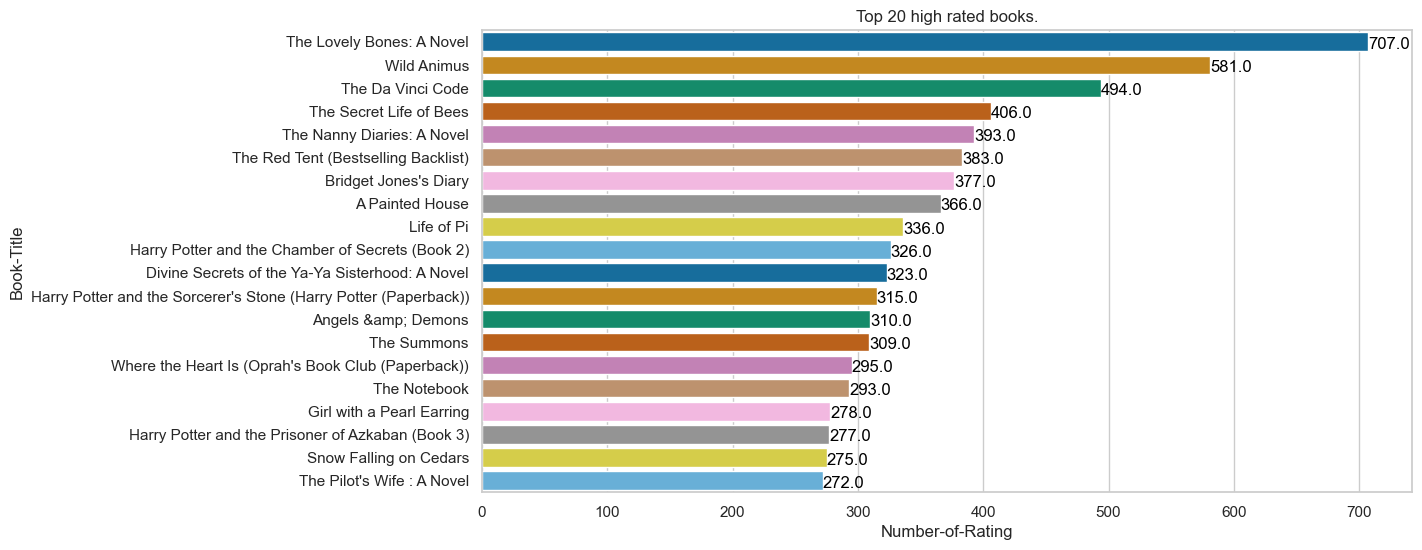

In [71]:
top_books = final_books.sort_values(by='Number-of-Rating', ascending=False).head(20)
sns.set(style='whitegrid')
plt.figure(figsize=(12,6))
color = sns.color_palette('colorblind')
ax = sns.barplot(x='Number-of-Rating', y='Book-Title', data=top_books, palette=color)

# Add labels to each bar (Average-Rating values)
for i in ax.patches:
    ax.text(i.get_width() + 0.05, i.get_y() + 0.5, f'{i.get_width():.1f}', 
            fontsize=12, color='black', va='center')

plt.title('Top 20 high rated books.')
plt.show()

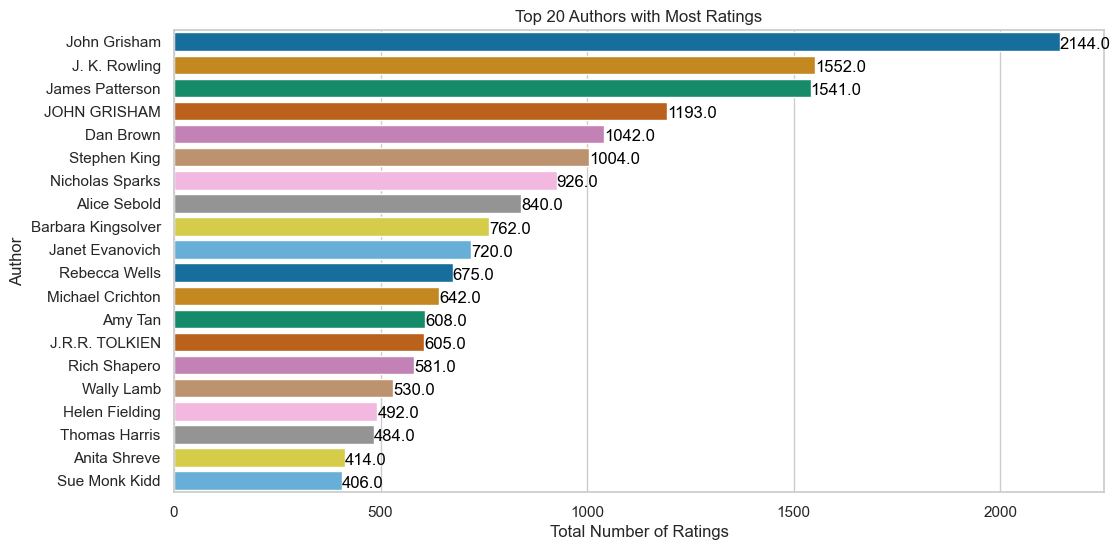

In [72]:
author_ratings = final_books.groupby('Book-Author')['Number-of-Rating'].sum().reset_index()

# Sort the authors by the number of ratings in descending order
top_authors = author_ratings.sort_values(by='Number-of-Rating', ascending=False).head(20)
sns.set(style='whitegrid')
# Set the figure size
plt.figure(figsize=(12, 6))
color = sns.color_palette('colorblind')
# Create a barplot with Seaborn
ax=sns.barplot(x='Number-of-Rating', y='Book-Author', data=top_authors, palette=color)
# Add labels to each bar (showing Average-Rating values)
for i in ax.patches:
    ax.text(i.get_width() + 0.05, i.get_y() + 0.5, f'{i.get_width():.1f}', 
            fontsize=12, color='black', va='center')

# Add a title and labels
plt.title('Top 20 Authors with Most Ratings')
plt.xlabel('Total Number of Ratings')
plt.ylabel('Author')

# Show the plot
plt.show()

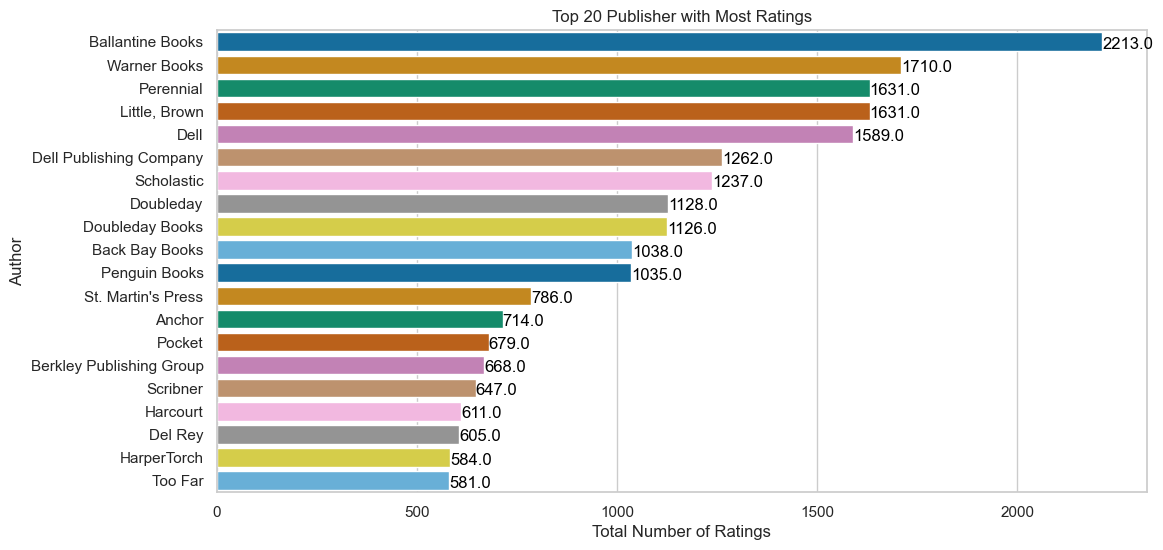

In [219]:
author_ratings = final_books.groupby('Publisher')['Number-of-Rating'].sum().reset_index()

# Sort the authors by the number of ratings in descending order
top_authors = author_ratings.sort_values(by='Number-of-Rating', ascending=False).head(20)
sns.set(style='whitegrid')
# Set the figure size
plt.figure(figsize=(12, 6))
color = sns.color_palette('colorblind')
# Create a barplot with Seaborn
ax=sns.barplot(x='Number-of-Rating', y='Publisher', data=top_authors, palette=color)
# Add labels to each bar (showing Average-Rating values)
for i in ax.patches:
    ax.text(i.get_width() + 0.05, i.get_y() + 0.5, f'{i.get_width():.1f}', 
            fontsize=12, color='black', va='center')

# Add a title and labels
plt.title('Top 20 Publisher with Most Ratings')
plt.xlabel('Total Number of Ratings')
plt.ylabel('Author')

# Show the plot
plt.show()

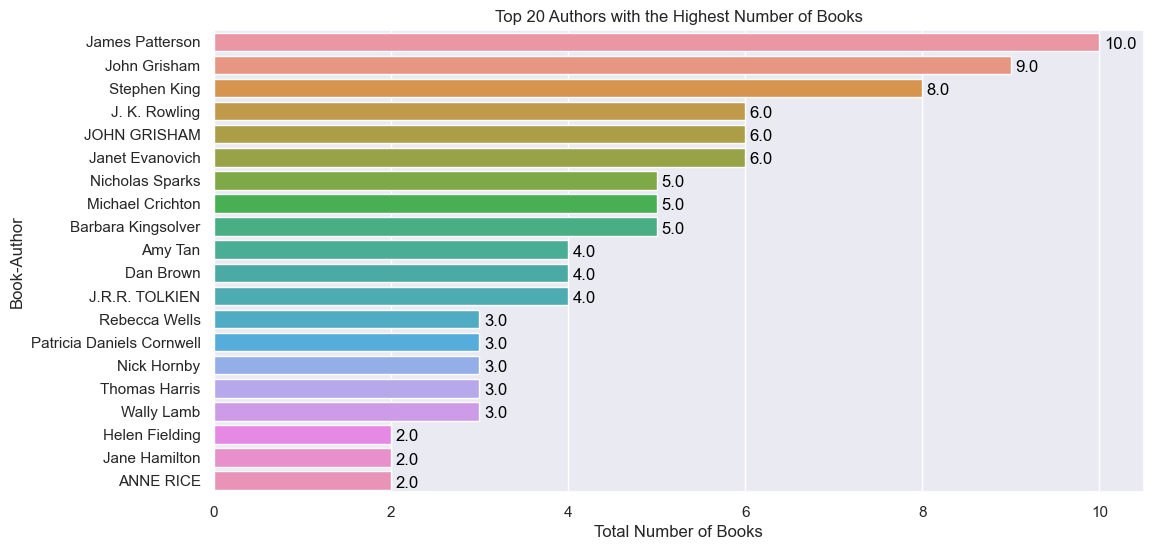

In [78]:
books_per_author = final_books.groupby('Book-Author').size().reset_index(name='Number_of_Books')
books_per_author = books_per_author.sort_values(by='Number_of_Books', ascending=False)

sns.set(style='darkgrid')
plt.figure(figsize=(12,6))

# Create a barplot of total_books vs Book-Author
ax = sns.barplot(y='Book-Author', x='Number_of_Books', data=books_per_author.head(20), order=books_per_author['Book-Author'].head(20))

# Add labels to each bar (counts of books)
for i in ax.patches:
    ax.text(i.get_width() + 0.05, i.get_y() + 0.5, f'{i.get_width():.1f}', 
            fontsize=12, color='black', va='center')

plt.title('Top 20 Authors with the Highest Number of Books')
plt.xlabel('Total Number of Books')
plt.show()